# XAI Faithfulness Evaluation

Measures how well IG and EG recover the **three injected ground-truth patterns** from the simulation, across all scenarios.

**Ground-truth patterns:**
- **Trigger** — ICD_10 at one visit in 1–10, followed by ATC_5 at the next visit. Contribution weight: +10 (dominant signal)
- **Escalation** — broad ICD spike across the last 3 visits. Contribution weight: +2.5
- **Chronic** — ICD_1, ICD_2, ICD_3 recurring throughout history. Contribution weight: +0.25 per occurrence (weakest)

**Three faithfulness metrics per phenotype per method:**
- **Spearman r** — rank correlation between |XAI| and ground-truth attribution (flattened over time × features per patient, then averaged)
- **Top-K feature hit** — fraction of patients where ≥1 ground-truth feature appears in the top-K features by mean |XAI|
- **Temporal precision** — fraction of total |XAI| mass that falls in the visits where the ground-truth signal actually occurs

**Requires:** `faithfulness.csv` in each scenario folder (produced by the pipeline after adding `run_faithfulness_evaluation()`).
If not yet run, Section 2 can compute them on the fly from saved `.npy` files.

---
## 1. Setup

In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display

OUT_DIR = "/home/hoepler/longitudinal_prediction_modeling/pipeline_out"
SIM_DIR = "/mnt/c/Users/hoepler/Documents/LifeSpanAI_OMEN/simulation_study_life_span_ai_omen/sim_outputs"

SCENARIOS = [
    "Baseline", "Small N", "Large N",
    "Rare Trigger", "Very Rare Trigger",
    "Short History", "Long History",
    "High Noise", "Very High Noise",
    "Stress Test",
]
MODELS  = ["GRU", "LSTM"]
METHODS = [f"{xai}_{m}" for xai in ["EG","IG"] for m in MODELS]

def sc_dir(name):
    return os.path.join(OUT_DIR, name.replace(" ", "_"))

# Ground-truth feature indices (0-based, in sorted feature_names list)
GT = {
    "TRIGGER_ICD": 41,   # ICD_10
    "TRIGGER_ATC": 35,   # ATC_5
    "CHRONIC_1":   40,   # ICD_1
    "CHRONIC_2":   52,   # ICD_2
    "CHRONIC_3":   63,   # ICD_3
}

# Load feature names (from any scenario — same across all)
feat_csv = os.path.join(sc_dir("Baseline"), "feature_names_N3000_V20_trig0.15_esc0.10_bg0.010.csv")
if os.path.exists(feat_csv):
    feat_df       = pd.read_csv(feat_csv)
    feature_names = feat_df["name"].tolist()
    print(f"Feature names loaded: {len(feature_names)} features")
    print(f"  GT tokens: { {k: feature_names[v] for k,v in GT.items()} }")
else:
    feature_names = None
    print("WARNING: feature_names CSV not found — run pipeline first or set manually")

---
## 2. Load Faithfulness Results

Reads the `faithfulness.csv` saved by the pipeline. If a scenario hasn't been run yet it is skipped with a warning.

In [2]:
faith_rows = []
missing    = []

for name in SCENARIOS:
    csv = os.path.join(sc_dir(name), "faithfulness.csv")
    if os.path.exists(csv):
        df = pd.read_csv(csv)
        df.insert(0, "scenario", name)
        faith_rows.append(df)
    else:
        missing.append(name)

if missing:
    print(f"WARNING — faithfulness.csv not found for: {missing}")
    print("Re-run the pipeline for those scenarios.")

if faith_rows:
    faith = pd.concat(faith_rows, ignore_index=True)
    print(f"Loaded {len(faith)} rows across {faith['scenario'].nunique()} scenarios")
    display(faith.head(12))
else:
    print("No results found. Run the pipeline first.")
    faith = pd.DataFrame()

WARNING — faithfulness.csv not found for: ['Baseline', 'Small N', 'Large N', 'Rare Trigger', 'Very Rare Trigger', 'Short History', 'Long History', 'High Noise', 'Very High Noise', 'Stress Test']
Re-run the pipeline for those scenarios.
No results found. Run the pipeline first.


---
## 3. Overview — Metric × Scenario × Method

One heatmap per metric. Rows = scenarios, columns = method × phenotype.

In [3]:
if not faith.empty:
    metrics = faith["metric"].unique()
    phenotypes = ["trigger", "escalation", "chronic"]

    for metric in metrics:
        sub = faith[faith["metric"] == metric]
        pivot = sub.pivot_table(
            index="scenario", columns=["method","phenotype"], values="value"
        )
        # Reorder rows to match SCENARIOS list
        pivot = pivot.reindex([s for s in SCENARIOS if s in pivot.index])
        # Only keep phenotypes of interest
        cols_keep = [c for c in pivot.columns if c[1] in phenotypes]
        pivot = pivot[cols_keep]

        fig, ax = plt.subplots(figsize=(max(14, len(pivot.columns)*1.4), 5))
        vmin = 0 if "precision" in metric or "hit" in metric else -0.1
        vmax = 1.0
        sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGn",
                    vmin=vmin, vmax=vmax, ax=ax,
                    linewidths=0.3, linecolor="#ddd")
        ax.set_title(f"Faithfulness: {metric}", fontsize=14, fontweight="bold")
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticklabels(
            [f"{m}\n{p}" for m, p in pivot.columns], rotation=30, ha="right", fontsize=9
        )
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

---
## 4. Deep Dive by Phenotype

One subplot per metric, one line per method, x-axis = scenarios.

In [4]:
if not faith.empty:
    phenotypes  = ["trigger", "escalation", "chronic"]
    phen_titles = {
        "trigger":    "Trigger (ICD_10 → ATC_5, visits 1–10, weight 10)",
        "escalation": "Escalation (broad ICD spike, last 3 visits, weight 2.5)",
        "chronic":    "Chronic (ICD_1/2/3, all visits, weight 0.25)",
    }
    metrics     = faith["metric"].unique()
    colors      = plt.cm.tab10.colors

    for phen in phenotypes:
        sub = faith[faith["phenotype"] == phen]
        if sub.empty:
            continue

        fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 5), sharey=False)
        if len(metrics) == 1:
            axes = [axes]

        for ax, metric in zip(axes, metrics):
            m_sub = sub[sub["metric"] == metric]
            for ci, method in enumerate(m_sub["method"].unique()):
                row = m_sub[m_sub["method"] == method].set_index("scenario")
                vals = [row.loc[s, "value"] if s in row.index else np.nan
                        for s in SCENARIOS]
                ax.plot(range(len(SCENARIOS)), vals,
                        marker="o", label=method,
                        color=colors[ci % len(colors)])

            ax.set_xticks(range(len(SCENARIOS)))
            ax.set_xticklabels(SCENARIOS, rotation=40, ha="right", fontsize=8)
            ax.set_ylabel(metric)
            ax.set_title(metric, fontsize=11)
            ax.set_ylim(-0.05, 1.05)
            ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
            ax.legend(fontsize=8)

        fig.suptitle(phen_titles[phen], fontsize=13, fontweight="bold")
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)
        plt.show()

---
## 5. EG vs IG Head-to-Head

Direct comparison of the two XAI methods for each model, averaged across scenarios. Shows which method is more faithful and whether the answer changes by phenotype or metric.

In [5]:
if not faith.empty:
    for model in MODELS:
        eg_col = f"EG_{model}"
        ig_col = f"IG_{model}"
        methods_avail = faith["method"].unique()
        if eg_col not in methods_avail or ig_col not in methods_avail:
            print(f"  {model}: EG or IG results missing, skipping")
            continue

        sub = faith[faith["method"].isin([eg_col, ig_col])]
        agg = (sub.groupby(["method","phenotype","metric"])["value"]
                  .mean().reset_index()
                  .pivot_table(index=["phenotype","metric"],
                               columns="method", values="value")
                  .round(3))
        agg["EG_wins"] = agg[eg_col] > agg[ig_col]
        agg["delta"]   = (agg[eg_col] - agg[ig_col]).round(3)

        print(f"\n── {model}: EG vs IG (mean across scenarios) ──")
        display(agg.style
                .background_gradient(subset=[eg_col, ig_col], cmap="YlGn", axis=None)
                .applymap(lambda v: "color: #1a7a4a; font-weight:bold" if v else
                                    "color: #b03030",
                          subset=["EG_wins"]))

---
## 6. Degradation Analysis

How does faithfulness degrade as the simulation becomes harder? Compares Baseline against the stress scenarios for each metric and phenotype.

**Scenario groups:**
- **Sample size**: Small N → Baseline → Large N
- **Trigger rarity**: Very Rare → Rare → Baseline
- **History length**: Short → Baseline → Long
- **Noise level**: Baseline → High → Very High

In [6]:
if not faith.empty:
    groups = {
        "Sample size":     ["Small N",          "Baseline",    "Large N"],
        "Trigger rarity":  ["Very Rare Trigger", "Rare Trigger","Baseline"],
        "History length":  ["Short History",     "Baseline",    "Long History"],
        "Noise level":     ["Baseline",          "High Noise",  "Very High Noise"],
    }
    phenotypes = ["trigger", "escalation", "chronic"]

    # Use EG_GRU as the reference method; change here if needed
    ref_method = "EG_GRU"

    sub = faith[(faith["method"] == ref_method) & (faith["phenotype"].isin(phenotypes))]

    fig, axes = plt.subplots(len(groups), len(phenotypes),
                              figsize=(5*len(phenotypes), 4*len(groups)),
                              sharey=False)

    for gi, (group_name, group_scenarios) in enumerate(groups.items()):
        for pi, phen in enumerate(phenotypes):
            ax = axes[gi][pi]
            g_sub = sub[(sub["phenotype"] == phen) &
                        (sub["scenario"].isin(group_scenarios))]
            for metric in g_sub["metric"].unique():
                m_sub = g_sub[g_sub["metric"] == metric].set_index("scenario")
                vals  = [m_sub.loc[s, "value"] if s in m_sub.index else np.nan
                         for s in group_scenarios]
                ax.plot(range(len(group_scenarios)), vals,
                        marker="o", label=metric)
            ax.set_xticks(range(len(group_scenarios)))
            ax.set_xticklabels(group_scenarios, rotation=20, ha="right", fontsize=9)
            ax.set_ylim(-0.05, 1.05)
            ax.axhline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.5)
            if pi == 0:
                ax.set_ylabel(group_name, fontsize=10, fontweight="bold")
            if gi == 0:
                ax.set_title(phen.capitalize(), fontsize=11, fontweight="bold")
            ax.legend(fontsize=7)

    fig.suptitle(f"Faithfulness degradation by scenario group ({ref_method})",
                 fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

---
## 7. Feature Attribution Spotlight

Directly visualises whether the GT features (ICD_10, ATC_5, ICD_1/2/3) are attributed higher importance than background features. Loads `eg_*.npy` files directly.

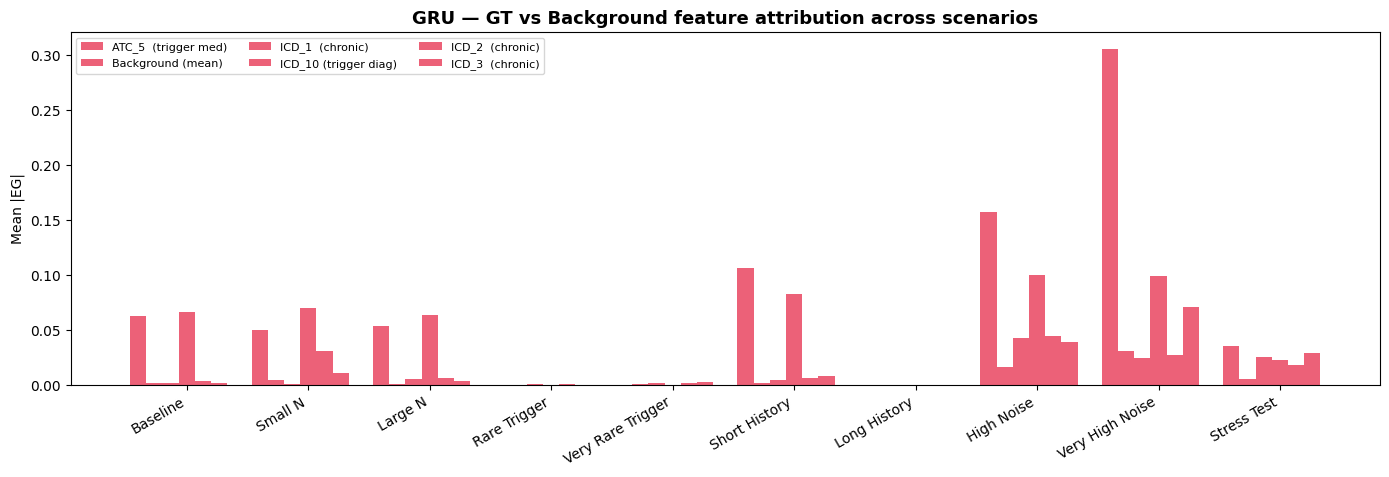

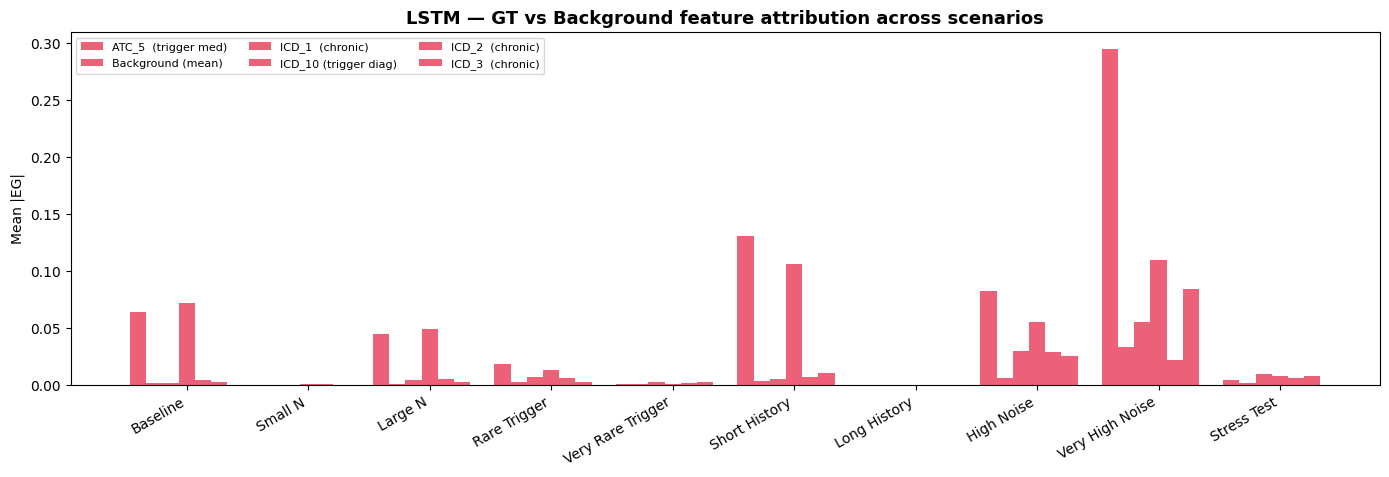

In [7]:
gt_feature_map = {
    "ICD_10 (trigger diag)": 41,
    "ATC_5  (trigger med)":  35,
    "ICD_1  (chronic)":      40,
    "ICD_2  (chronic)":      52,
    "ICD_3  (chronic)":      63,
}
BACKGROUND_SAMPLE = 20   # random background features to compare against

for model in MODELS:
    rows_data = []
    for name in SCENARIOS:
        npy = os.path.join(sc_dir(name), f"eg_{model.lower()}.npy")
        if not os.path.exists(npy):
            continue
        eg = np.load(npy)   # (N_test, T, F)
        mean_abs = np.mean(np.abs(eg), axis=(0, 1))   # (F,)

        for label, idx in gt_feature_map.items():
            rows_data.append({"scenario": name, "feature": label,
                               "type": "GT", "mean_abs_eg": mean_abs[idx]})

        # Sample background (non-GT) features
        np.random.seed(42)
        bg_idx = np.random.choice(
            [i for i in range(140) if i not in gt_feature_map.values()],
            BACKGROUND_SAMPLE, replace=False
        )
        rows_data.append({"scenario": name, "feature": "Background (mean)",
                           "type": "BG",
                           "mean_abs_eg": mean_abs[bg_idx].mean()})

    if not rows_data:
        print(f"{model}: no .npy files found")
        continue

    df_spot = pd.DataFrame(rows_data)
    pivot_spot = df_spot.pivot_table(
        index="scenario", columns="feature", values="mean_abs_eg"
    ).reindex([s for s in SCENARIOS if s in df_spot["scenario"].values])

    fig, ax = plt.subplots(figsize=(14, 5))
    x = np.arange(len(pivot_spot))
    ncols = len(pivot_spot.columns)
    width = 0.8 / ncols
    for ci, col in enumerate(pivot_spot.columns):
        color = "#e94560" if "BG" not in col else "#aaaaaa"
        ax.bar(x + ci*width, pivot_spot[col], width=width,
               label=col, color=color, alpha=0.85)
    ax.set_xticks(x + width*ncols/2)
    ax.set_xticklabels(pivot_spot.index, rotation=30, ha="right")
    ax.set_ylabel("Mean |EG|")
    ax.set_title(f"{model} — GT vs Background feature attribution across scenarios",
                 fontsize=13, fontweight="bold")
    ax.legend(fontsize=8, ncol=3)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

---
## 8. Summary Table

Single table of all faithfulness results — export-ready for a paper.

In [8]:
if not faith.empty:
    summary = (faith
               .groupby(["scenario", "method", "phenotype", "metric"])["value"]
               .mean()
               .reset_index()
               .pivot_table(index=["scenario","phenotype"],
                            columns=["method","metric"],
                            values="value")
               .round(3))
    summary = summary.reindex([s for s in SCENARIOS if s in summary.index.get_level_values(0)])
    summary.to_csv(os.path.join(OUT_DIR, "faithfulness_summary.csv"))
    print(f"Saved → {os.path.join(OUT_DIR, 'faithfulness_summary.csv')}")
    display(summary)